# Slope-spatial

Visualize wind and wave parameters in storm-centered reference frame.

In [24]:
from typing import List, Tuple, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Arc

from configure import read_stored_variable
from src import plotting

# Setup

In [25]:
%%capture
# %run 'nb7-slope-alignment.ipynb'
%run -i configure.py

In [26]:
microswift_df = read_stored_variable('microswift_df')
spotter_df = read_stored_variable('spotter_df')
coamps_ds = read_stored_variable('coamps_ds')
coamps_xy_ds = read_stored_variable('coamps_xy_ds')
ibtracs_df = read_stored_variable('ibtracs_df')
time_slice = read_stored_variable('time_slice')

plotting.configure_figures()

GLOBAL_SUFFIX = '' #'_spotter_and_microswift'

## Storm-centered maps

Plot the buoy drift tracks (in storm-relative coordinates) on a storm-centered map.  Normalize distances by the radius of maximum wind.  For context, draw rings corresponding to the NHC 34, 50, and 64 knot wind radii.

In [27]:
def plot_wind_radii(
    ibtracs_df: pd.DataFrame,
    ax: mpl.axes.Axes,
    radii_colors: dict,
    normalize_by_rmw: bool = True,
    **kwargs
) -> None:
    """ Plot NHC 34, 50, and 64 knot wind radii as concentric rings. """
    if normalize_by_rmw:
        rmw = nmi_to_km(ibtracs_df['USA_RMW'])
    else:
        rmw = 1

    for speed in ['34', '50', '64']:
        ne_radii = nmi_to_km(ibtracs_df[f'USA_R{speed}_NE']) / rmw
        nw_radii = nmi_to_km(ibtracs_df[f'USA_R{speed}_NW']) / rmw
        sw_radii = nmi_to_km(ibtracs_df[f'USA_R{speed}_SW']) / rmw
        se_radii = nmi_to_km(ibtracs_df[f'USA_R{speed}_SE']) / rmw

        patch = plot_wind_radii_mean_arc(ne_radii, nw_radii, sw_radii, se_radii,
                                         edgecolor=radii_colors[speed],
                                         **kwargs)
        ax.add_collection(patch)


def plot_wind_radii_mean_arc(
    ne_radii: pd.Series,
    nw_radii: pd.Series,
    sw_radii: pd.Series,
    se_radii: pd.Series,
    center: Tuple = (0,0),
    **arc_kwargs
) -> PatchCollection:
    """ Return a patch collection of arcs representing the mean radii. """
    n_arc = Arc(center, width=2*ne_radii.mean(), height=2*nw_radii.mean(), angle=45, theta1=0, theta2=90)
    w_arc = Arc(center, width=2*sw_radii.mean(), height=2*nw_radii.mean(), angle=45, theta1=90, theta2=180)
    s_arc = Arc(center, width=2*sw_radii.mean(), height=2*se_radii.mean(), angle=45, theta1=180, theta2=270)
    e_arc = Arc(center, width=2*ne_radii.mean(), height=2*se_radii.mean(), angle=45, theta1=270, theta2=360)
    return PatchCollection([n_arc, w_arc, s_arc, e_arc], facecolor='none', **arc_kwargs)


def create_radii_legend_elements(radii_colors: dict) -> List[Line2D]:
    """ Return legend elements for the wind radii. """
    legend_elements = [
        Line2D([0], [0], color=radii_colors['34'], label='34 kt winds'),
        Line2D([0], [0], color=radii_colors['50'], label='50 kt winds'),
        Line2D([0], [0], color=radii_colors['64'], label='64 kt winds'),
    ]
    return legend_elements


def nmi_to_km(nmi: np.ndarray) -> np.ndarray:
    """ Convert nautical miles to kilometers. """
    return nmi * 1.852


def plot_storm_center(ax: mpl.axes.Axes, **kwargs) -> None:
    """ Plot the storm center as a hurricane symbol and upwards arrow. """
    arrow_kwargs = dict(  #TODO: used for RMW norm
        dx=0,
        dy=1,
        width=0.2,
        color='k',
    )
    ax.arrow(0, 0, **arrow_kwargs, **kwargs)
    plotting.plot_hurricane_symbol(
        ax,
        xy=(0, 0),
        annotation_bbox_kwargs={'zorder': 5}
    )


In [28]:
def plot_drifter_storm_frame_trails(
    ax: mpl.axes.Axes,
    spotter_df: Optional[pd.DataFrame] = None,
    microswift_df: Optional[pd.DataFrame] = None,
    ibtracs_df: Optional[pd.DataFrame] = None,
    color_column_name: Optional[str] = None,
    plot_legend: bool = True,
    **trail_kwargs
):
    """ Plot drifter trails on a storm-centered map. """
    EXTENT = 16
    NORMALIZE_BY_RMW = True

    # Plot the storm center
    plot_storm_center(ax)

    marker_handles = []
    # Spotters
    if spotter_df is not None:
        spotter_markers = plotting.plot_drifter_storm_frame(
            spotter_df,
            ax=ax,
            label=plotting.get_drifter_label('spotter'),
            first_only=True,
            normalize_by_rmw=NORMALIZE_BY_RMW,
            **plotting.spotter_map_kwargs,
        )

        spotter_trails = plotting.plot_drifter_storm_frame(
            spotter_df,
            ax=ax,
            color_column_name=color_column_name,
            first_only=False,
            **trail_kwargs,
        )
        marker_handles.append(spotter_markers)
    else:
        spotter_markers = None
        spotter_trails = None

    # MicroSWIFTs
    if microswift_df is not None:
        microswift_markers = plotting.plot_drifter_storm_frame(
            microswift_df,
            ax=ax,
            label=plotting.get_drifter_label('microswift'),
            first_only=True,
            normalize_by_rmw=NORMALIZE_BY_RMW,
            **plotting.microswift_map_kwargs,
        )
        microswift_trails = plotting.plot_drifter_storm_frame(
            microswift_df,
            ax=ax,
            color_column_name=color_column_name,
            first_only=False,
            **trail_kwargs,
        )
        marker_handles.append(microswift_markers)
    else:
        microswift_markers = None
        microswift_trails = None

    radii_kwargs = {'alpha': 0.75, 'linewidth':1.5, 'zorder':0}
    radii_colors = {'34': 'lightgrey', '50': 'darkgrey', '64': 'dimgrey'}

    # Plot 34 kt, 50 kt, and 64 kt wind radii
    if ibtracs_df is not None:
        plot_wind_radii(
            ibtracs_df,
            ax,
            radii_colors,
            normalize_by_rmw=NORMALIZE_BY_RMW,
            **radii_kwargs,
        )
        radii_labels = create_radii_legend_elements(radii_colors)

    ax.set_ylim(EXTENT * np.array([-1, 1]))
    ax.set_xlim(EXTENT * np.array([-1, 1]))
    ax.set_aspect('equal')
    ax.set_ylabel('y-distance / RMW (-)', labelpad=-3)
    ax.set_xlabel('x-distance / RMW (-)', labelpad=5)
    if plot_legend:
        #TODO: error raised if no ibtracs_df
        ax.legend(
            handles=[*marker_handles, *radii_labels],
            loc='upper left',
            frameon=False
        )

    marker_plots = (spotter_markers, microswift_markers)
    trail_plots = (spotter_trails, microswift_trails)
    return marker_plots, trail_plots


### Time

Plot drift trails colored by time.  For colormapping, the time must be in a numeric format.

In [29]:
spotter_df['time_numeric'] = pd.to_numeric(spotter_df.index.get_level_values('time'))
microswift_df['time_numeric'] = pd.to_numeric(microswift_df.index.get_level_values('time'))

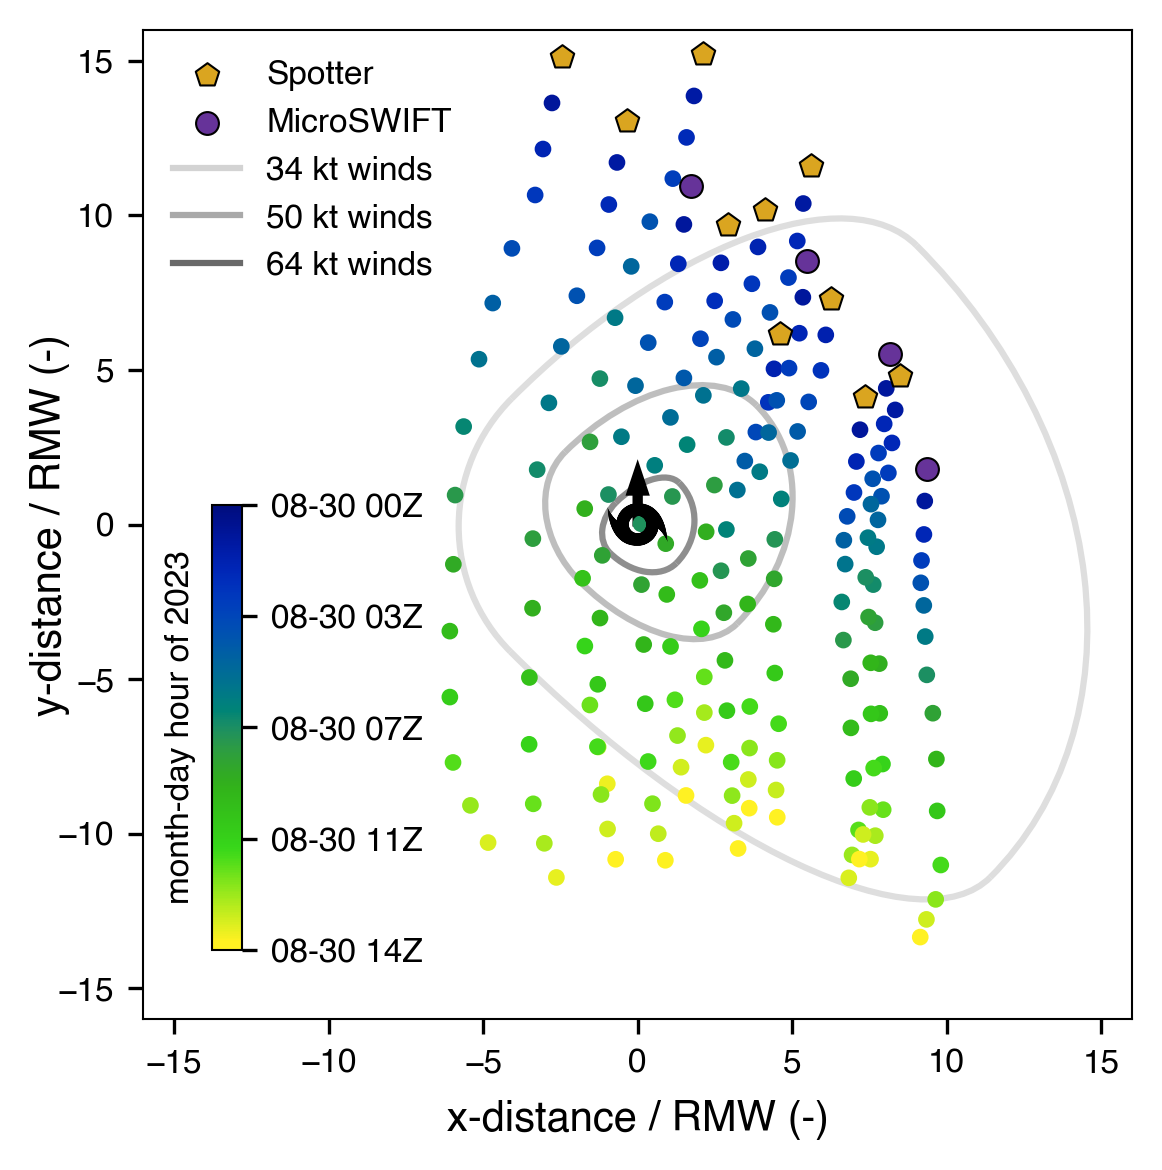

In [30]:
FIG_TITLE = (f"afig-hurricane_idalia_storm_frame_time_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_mean_square_slope_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'time_numeric' #'mean_square_slope',
    cmap = plotting.time_plot_kwargs['cmap']
    norm = plotting.time_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax=ax,
        bounds=[0.07, 0.07, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')

    start_date = kwargs['spotter_df'][color_column_name].min()
    end_date = kwargs['spotter_df'][color_column_name].max()

    cbar_ticks = pd.date_range(
        start=pd.to_datetime(start_date),
        end=pd.to_datetime(end_date),
        periods=5,
    )
    cbar.ax.set_ylim([end_date, start_date])
    cbar.set_ticks(
        pd.to_numeric(cbar_ticks),
        labels=cbar_ticks.strftime('%m-%d %HZ')
    )
    cbar.set_label('month-day hour of 2023', fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

plot_mean_square_slope_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)


### Bearing

Plot drift trails colored by bearing to the storm (this is mostly a check).

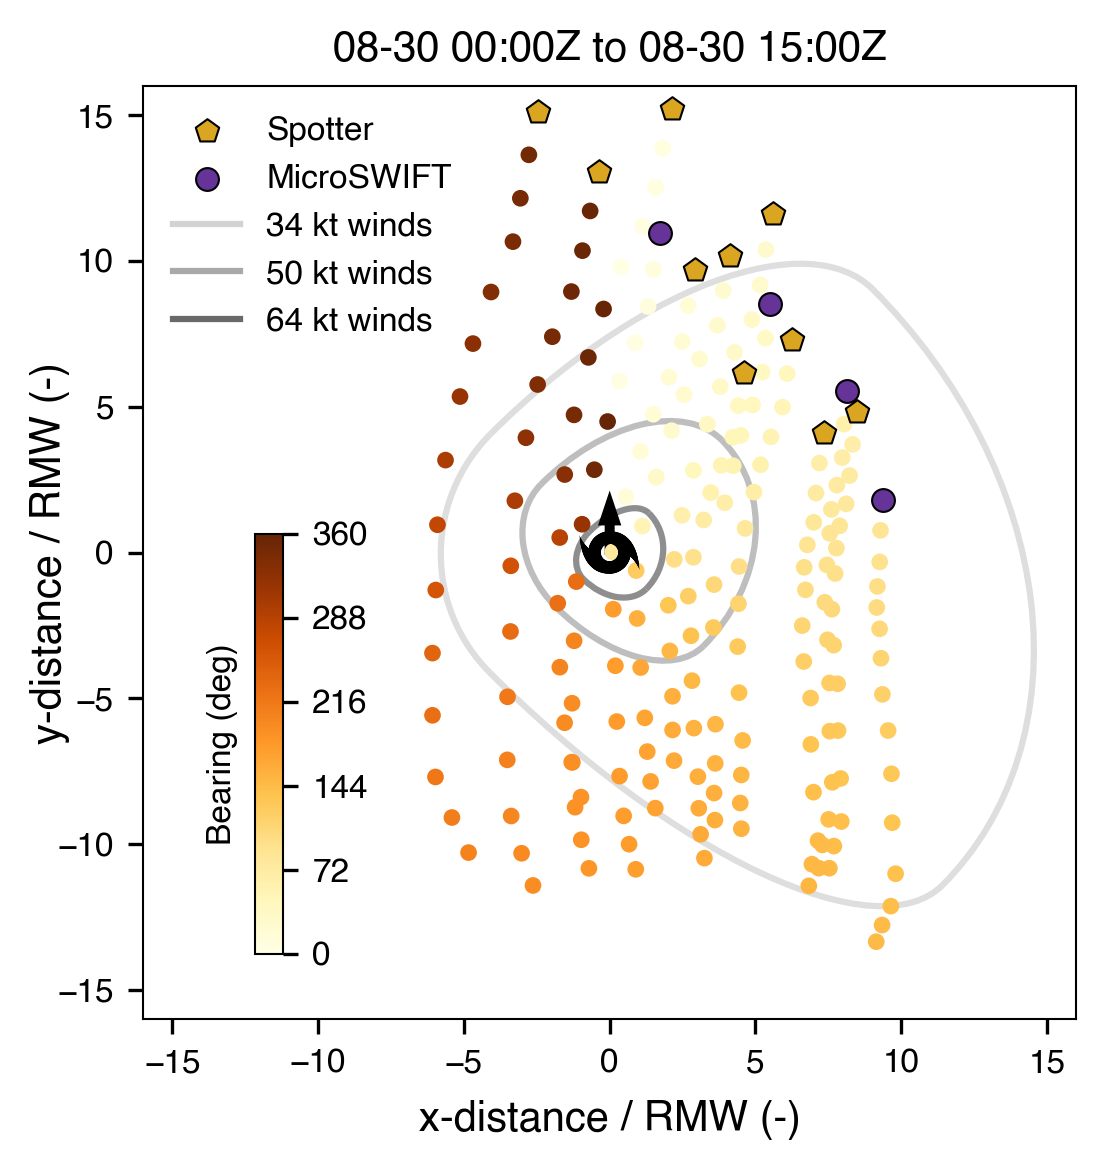

In [31]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_bearing_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_bearing_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'storm_frame_back_bearing'
    cmap = 'YlOrBr'
    norm = mpl.colors.Normalize(vmin=0, vmax=360)

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.12, 0.07, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 6))
    cbar.set_label('Bearing (deg)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

microswift_df['storm_frame_back_bearing'] = (microswift_df['storm_back_bearing'] - microswift_df['storm_heading']) % 360
spotter_df['storm_frame_back_bearing'] = (spotter_df['storm_back_bearing'] - spotter_df['storm_heading']) % 360

plot_bearing_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Mean square slope

Plot drift trails colored by mean square slope.

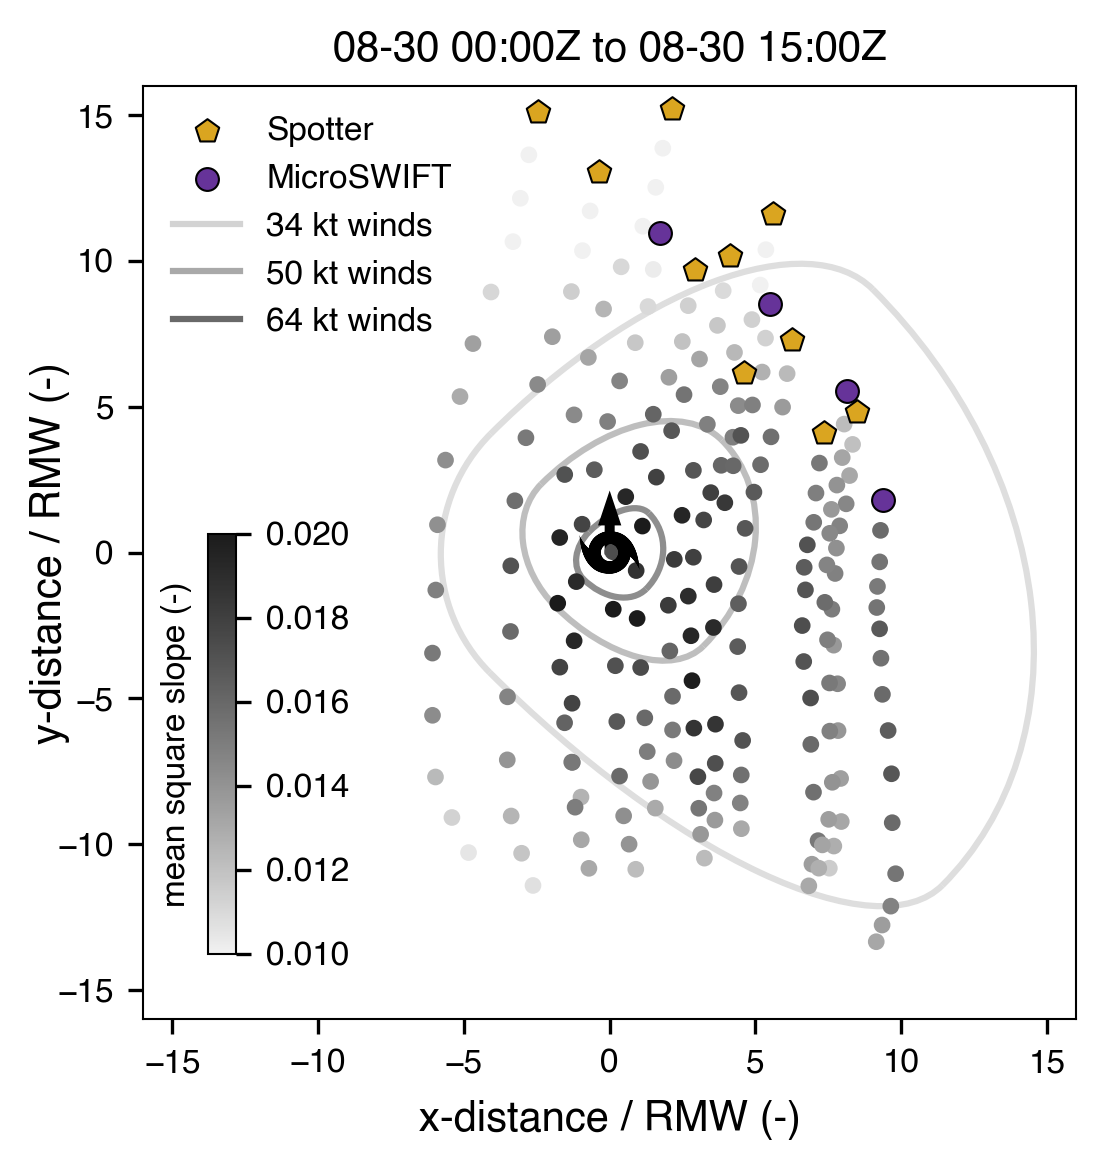

In [32]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_mss_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_mean_square_slope_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mean_square_slope_intrinsic' #'mean_square_slope',
    cmap = plotting.mean_square_slope_plot_kwargs['cmap']
    norm = plotting.mean_square_slope_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax=ax,
        bounds=[0.07, 0.07, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('mean square slope (-)', fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_mean_square_slope_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)


### Pressure

Plot drift trails colored by sea level pressure.

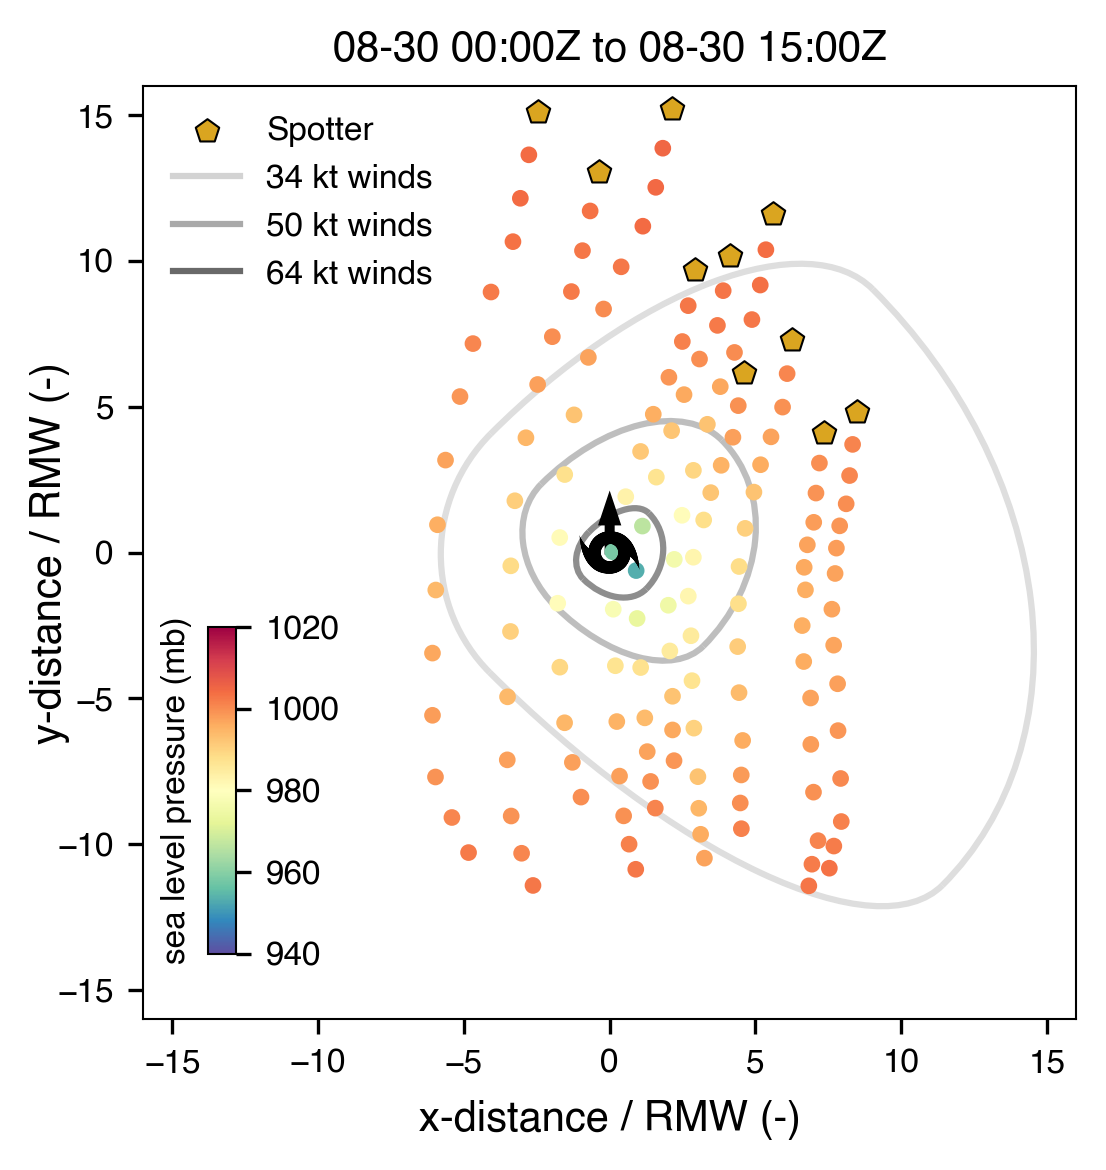

In [33]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_pressures_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_pressure_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'sea_level_pressure'
    cmap = plotting.pressure_plot_kwargs['cmap']
    norm = plotting.pressure_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.07, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('sea level pressure (mb)', fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_pressure_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    # microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Wind speed

Plot drift trails colored by colocated COAMPS-TC wind speed.

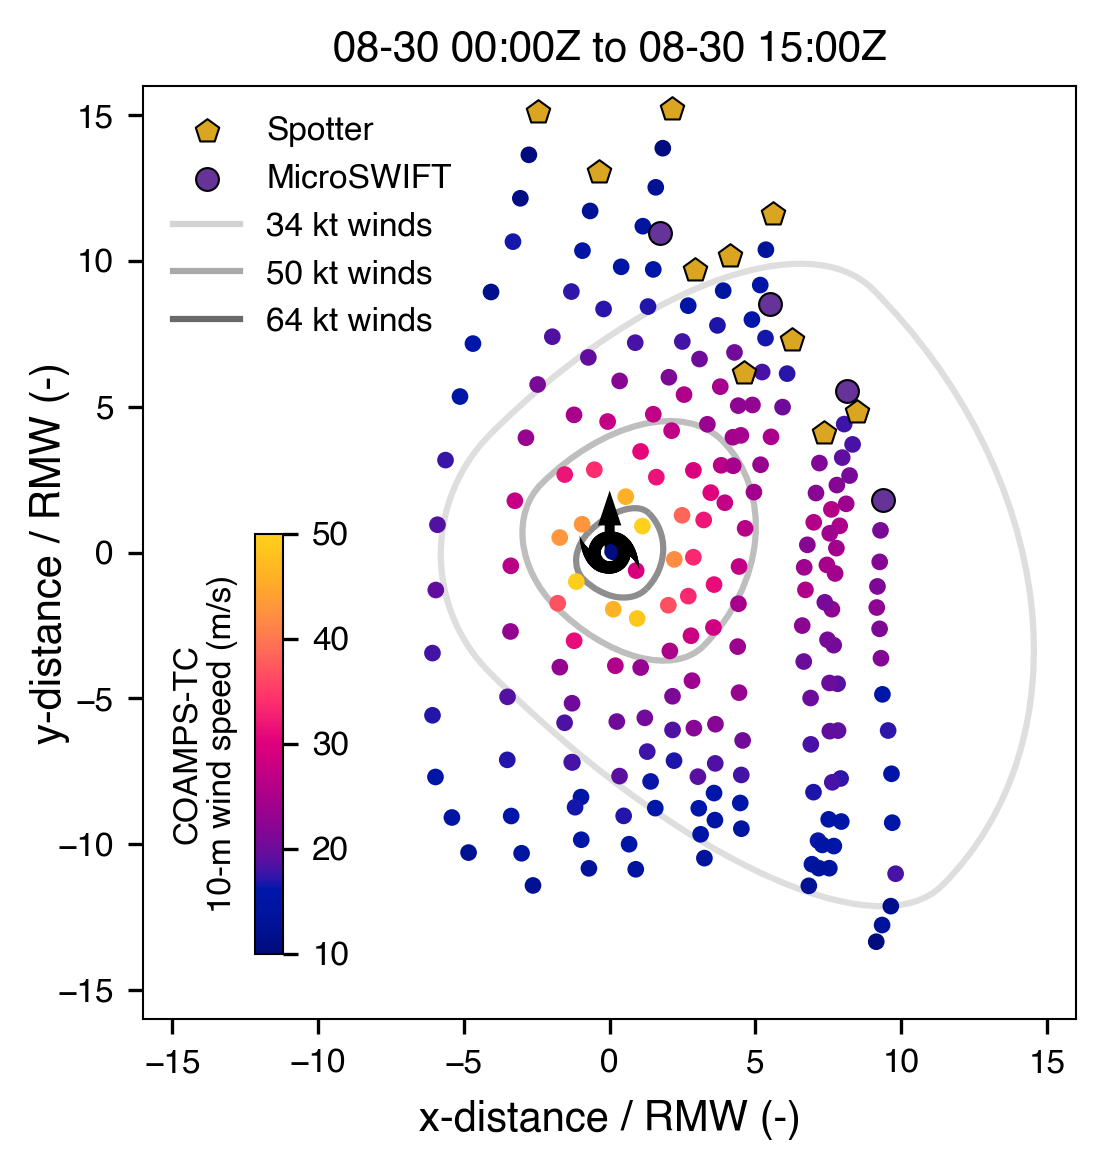

In [34]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_wind_speeds_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_wind_speed_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'wind_speed'
    cmap = plotting.wind_speed_plot_kwargs['cmap']
    norm = plotting.wind_speed_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.12, 0.07, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    # cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 6))
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 5))
    cbar.set_label('COAMPS-TC\n10-m wind speed (m/s)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_wind_speed_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

## Significant wave height

Plot drift trails colored by significant wave height.

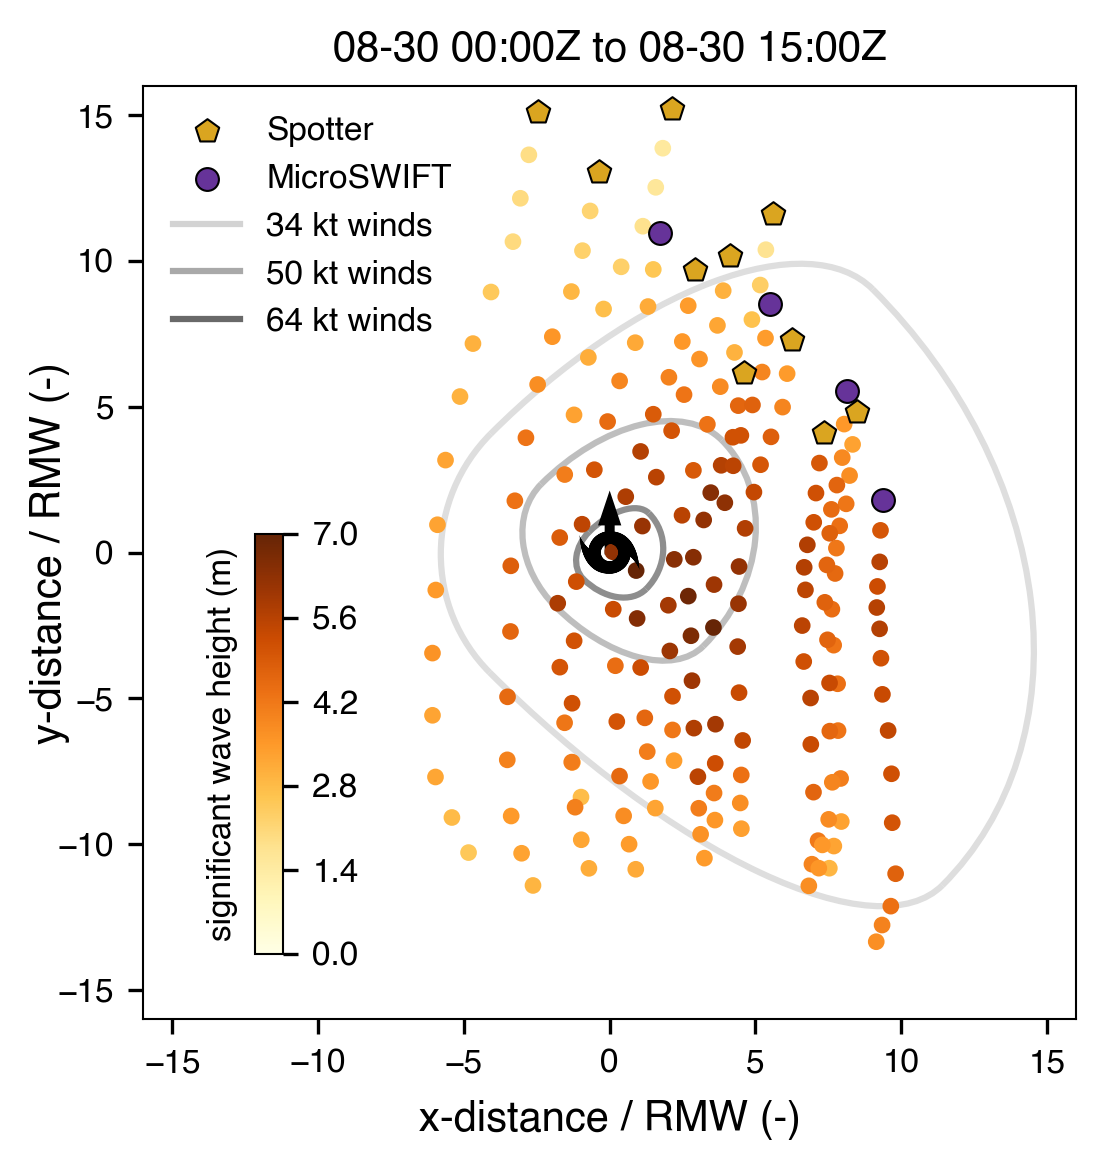

In [35]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_significant_height_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_significant_height_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'significant_height'
    cmap = 'YlOrBr'
    norm = mpl.colors.Normalize(vmin=0, vmax=7)

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.12, 0.07, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 6))
    cbar.set_label('significant wave height (m)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_significant_height_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Depth

Plot drift trails colored by colocated depth.

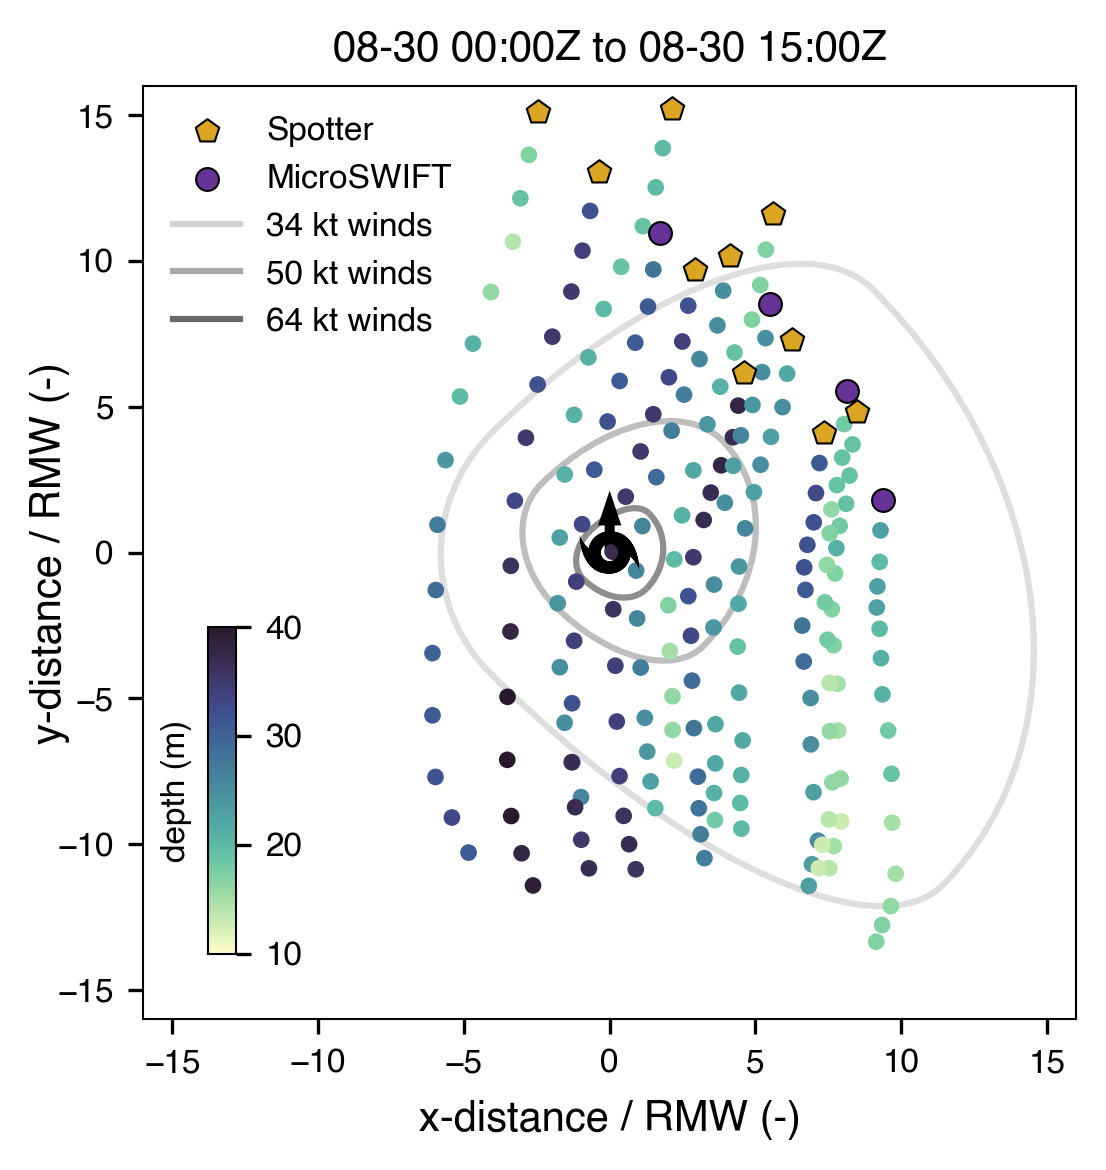

In [36]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_depth_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_depth_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'depth'
    cmap = plotting.depth_plot_kwargs['cmap']
    norm = plotting.depth_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.07, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('depth (m)', fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_depth_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Wave Age

Plot drift trails colored by energy-weighted (mean) inverse wave age.

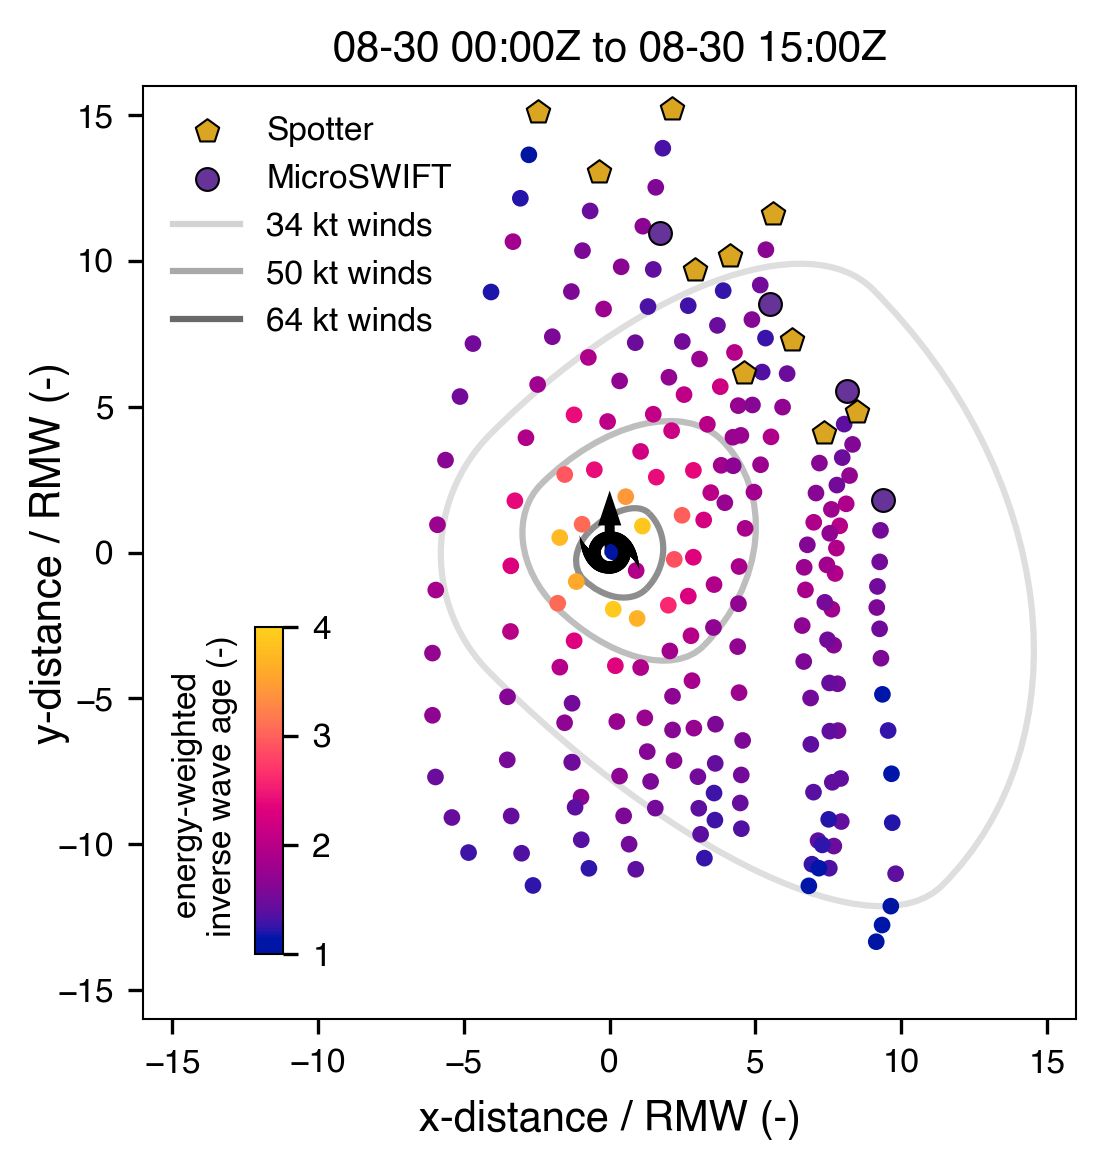

In [37]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_energy_weighted_inverse_wave_age_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_energy_weighted_inverse_wave_age_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mean_inverse_wave_age'
    cmap = plotting.mean_inverse_wave_age_plot_kwargs['cmap']
    norm = plotting.mean_inverse_wave_age_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.12, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('energy-weighted \n inverse wave age (-)',
                    fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_energy_weighted_inverse_wave_age_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Mean square slope residuals

Plot drift trails colored by mean square slope residuals.

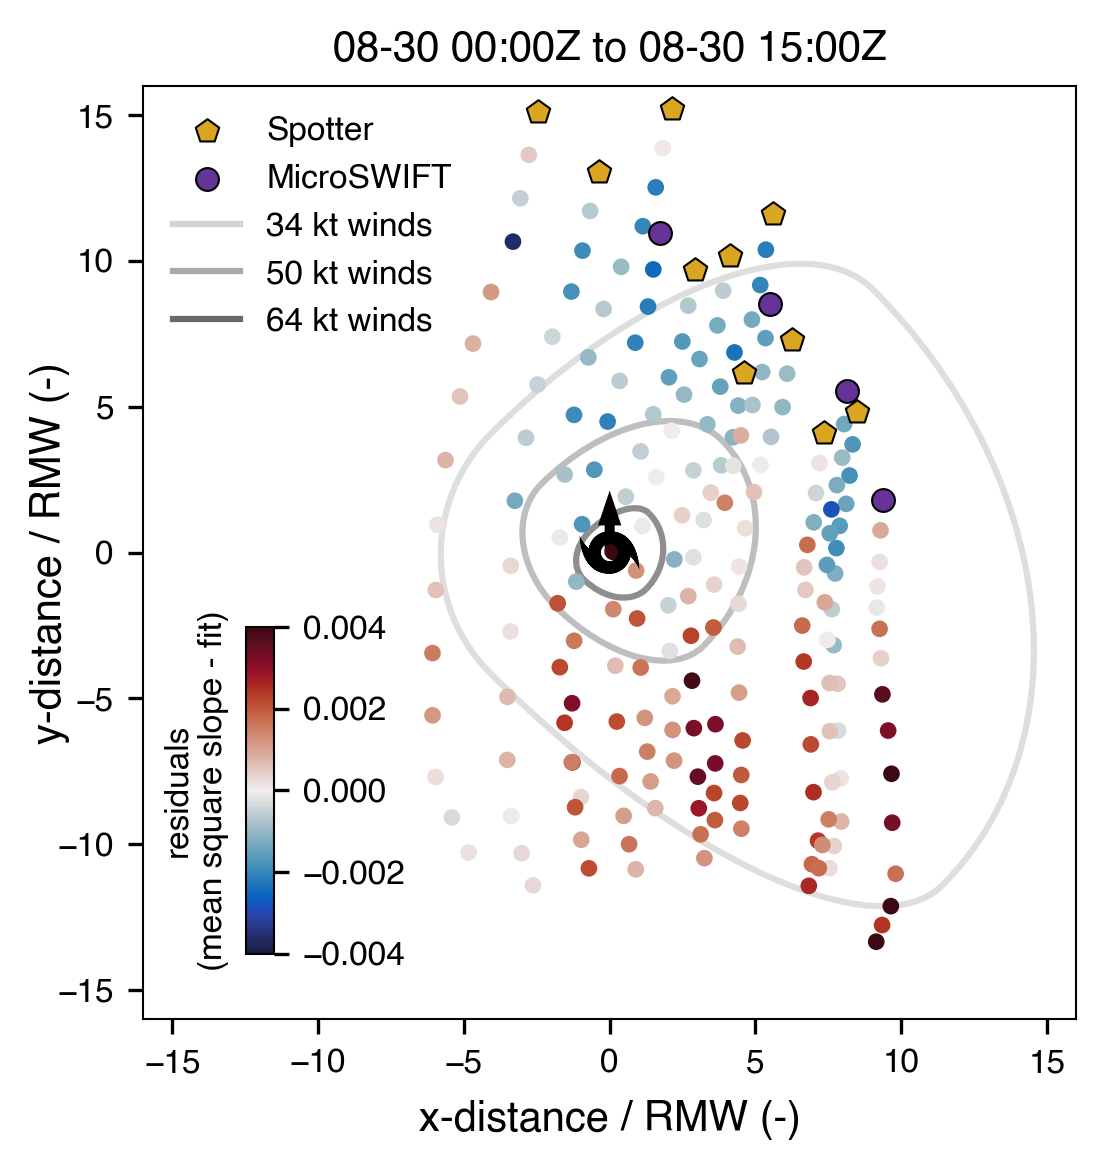

In [38]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_mss_fit_residuals_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_mean_square_slope_residuals_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mean_square_slope_intrinsic_residual' #'mean_square_slope',
    cmap = plotting.mean_square_slope_residual_plot_kwargs['cmap']
    norm = plotting.mean_square_slope_residual_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.11, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('residuals\n(mean square slope - fit)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_mean_square_slope_residuals_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Wind-wave alignment

#### Energy-weighted, signed

Plot drift trails colored by energy-weighted (mean), signed wind-wave alignment.

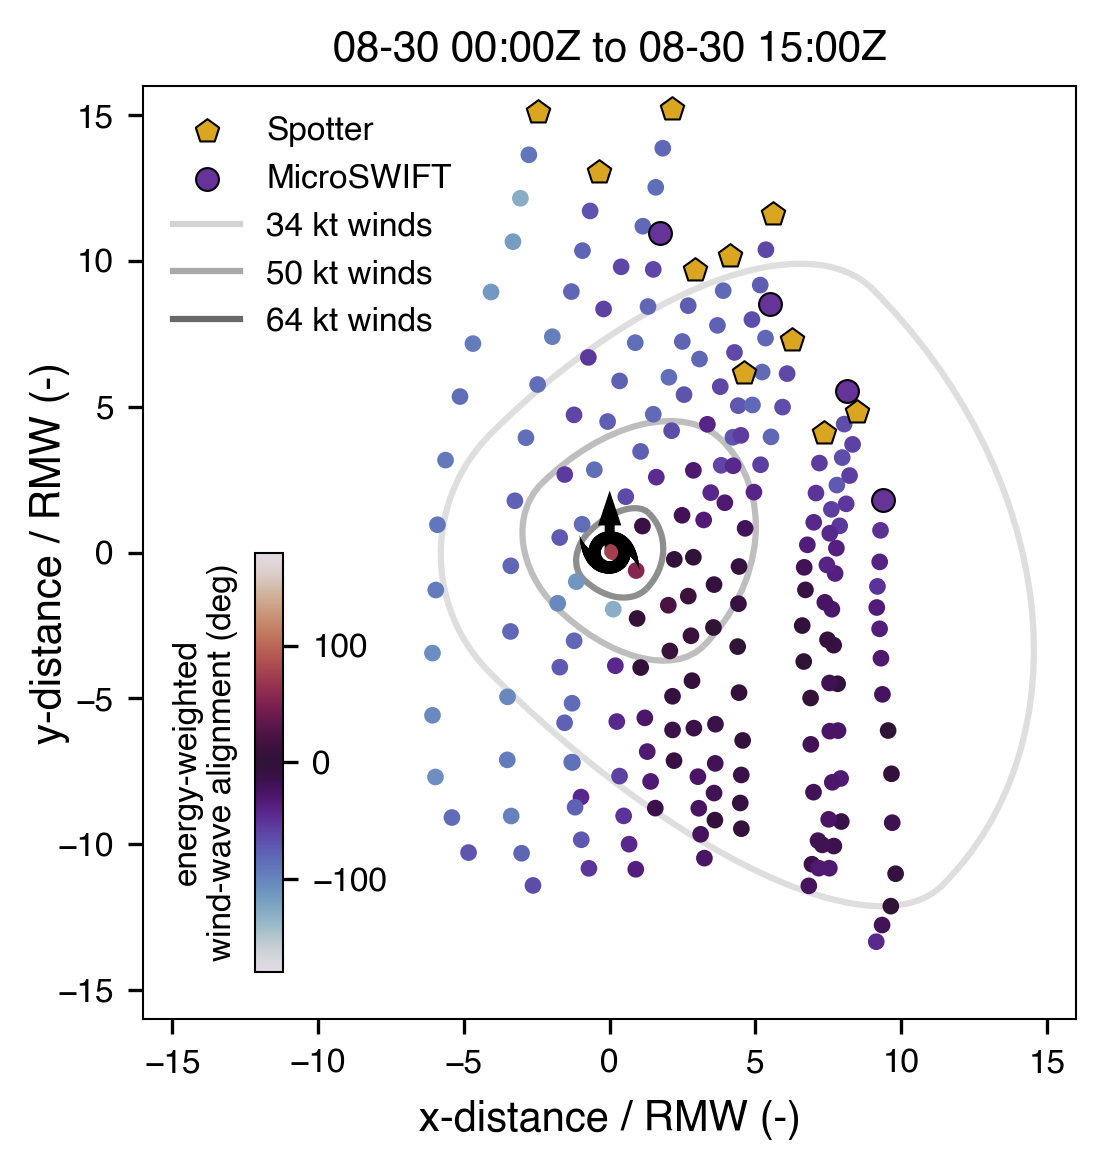

In [39]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_signed_energy_weighted_alignment")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_energy_weighted_alignment_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mean_wind_wave_alignment'
    cmap = plotting.wind_wave_alignment_signed_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_signed_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.12, 0.05, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('energy-weighted\nwind-wave alignment (deg)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_energy_weighted_alignment_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

#### Peak, signed

Plot drift trails colored by peak, signed wind-wave alignment.

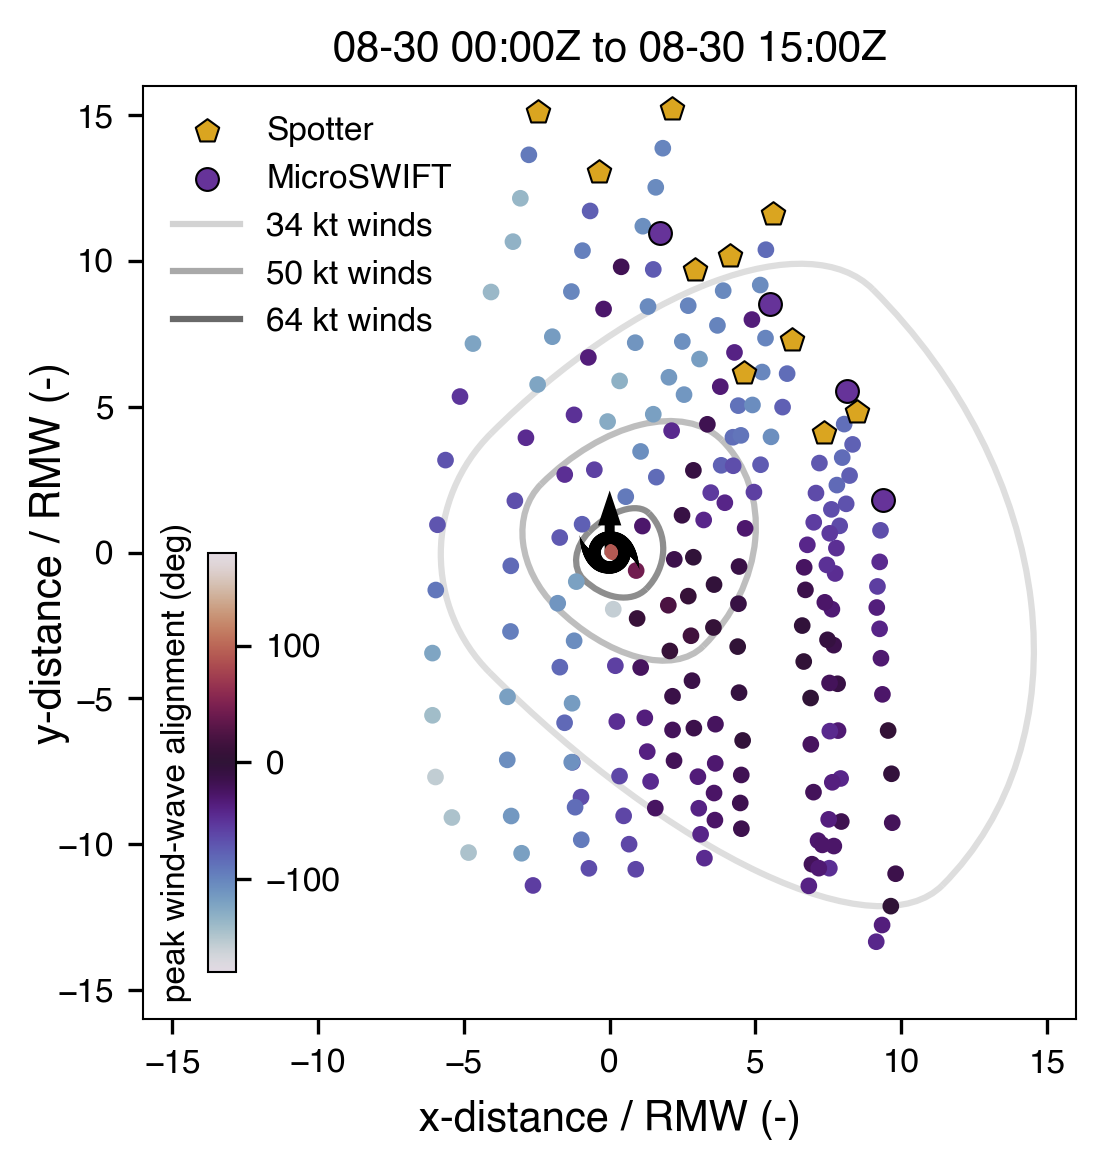

In [40]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_signed_peak_alignment_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_peak_alignment_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'peak_wind_wave_alignment'
    cmap = plotting.wind_wave_alignment_signed_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_signed_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.07, 0.05, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('peak wind-wave alignment (deg)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_peak_alignment_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

#### Energy-weighted, absolute

Plot drift trails colored by energy-weighted (mean), absolute wind-wave alignment.

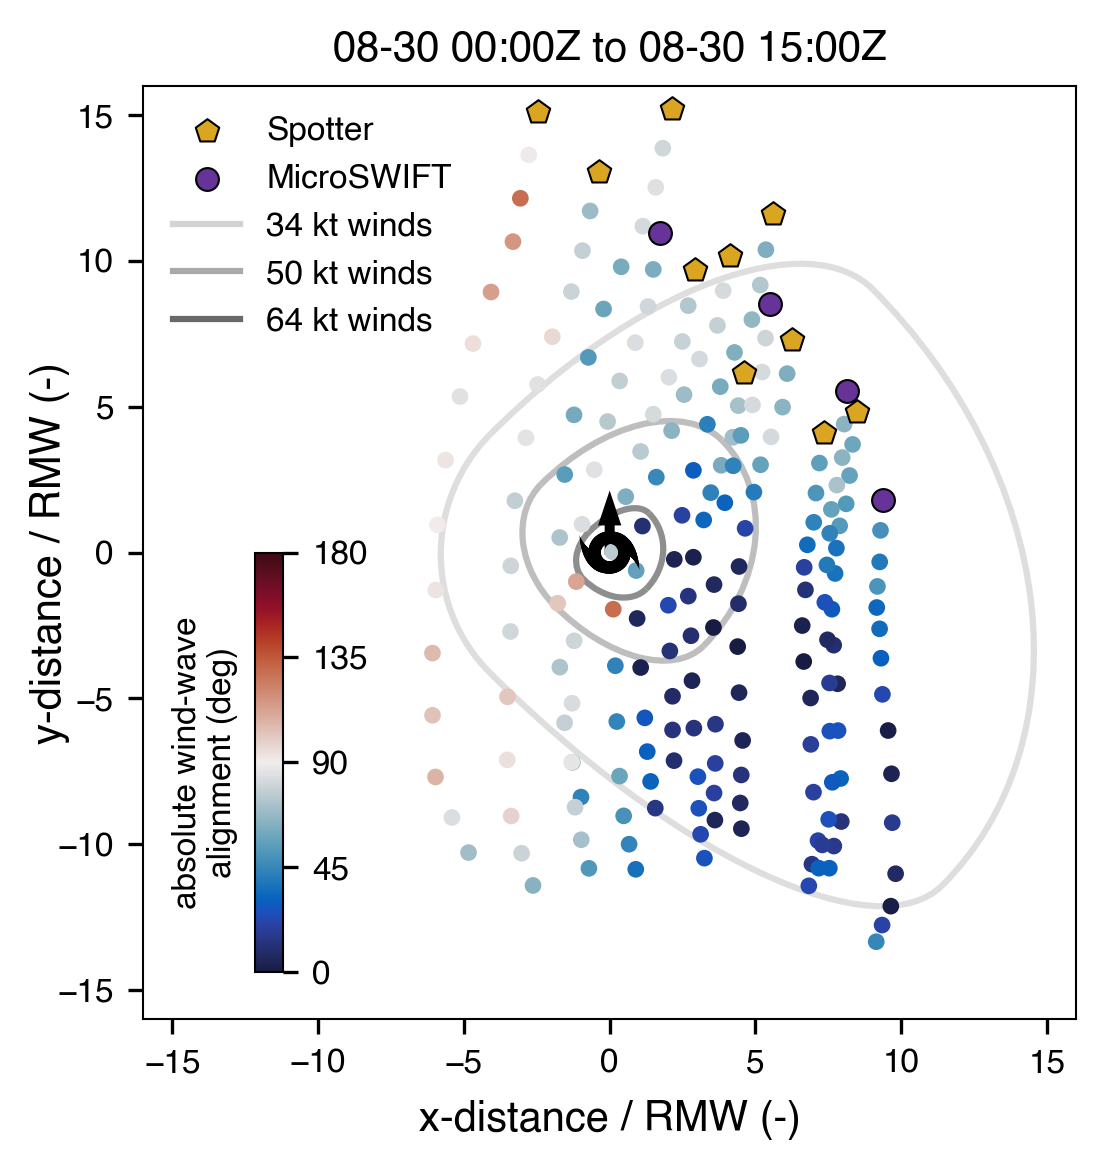

In [41]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_abs_energy_weighted_alignment_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_abs_energy_weighted_alignment_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mean_wind_wave_alignment_abs'
    cmap = plotting.wind_wave_alignment_abs_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_abs_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.12, 0.05, 0.03, 0.45]
    )
    # cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_ticks(np.linspace(norm.vmin, norm.vmax, 5))
    cbar.set_label('absolute wind-wave\nalignment (deg)',
                   fontsize=plotting.small_font_size)
    # cbar.ax.text(0.5, 45/2, 'aligned', ha='center', va='center', fontsize=6, color='w', rotation=90)
    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_abs_energy_weighted_alignment_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

#### Peak, absolute

Plot drift trails colored by peak, absolute wind-wave alignment.

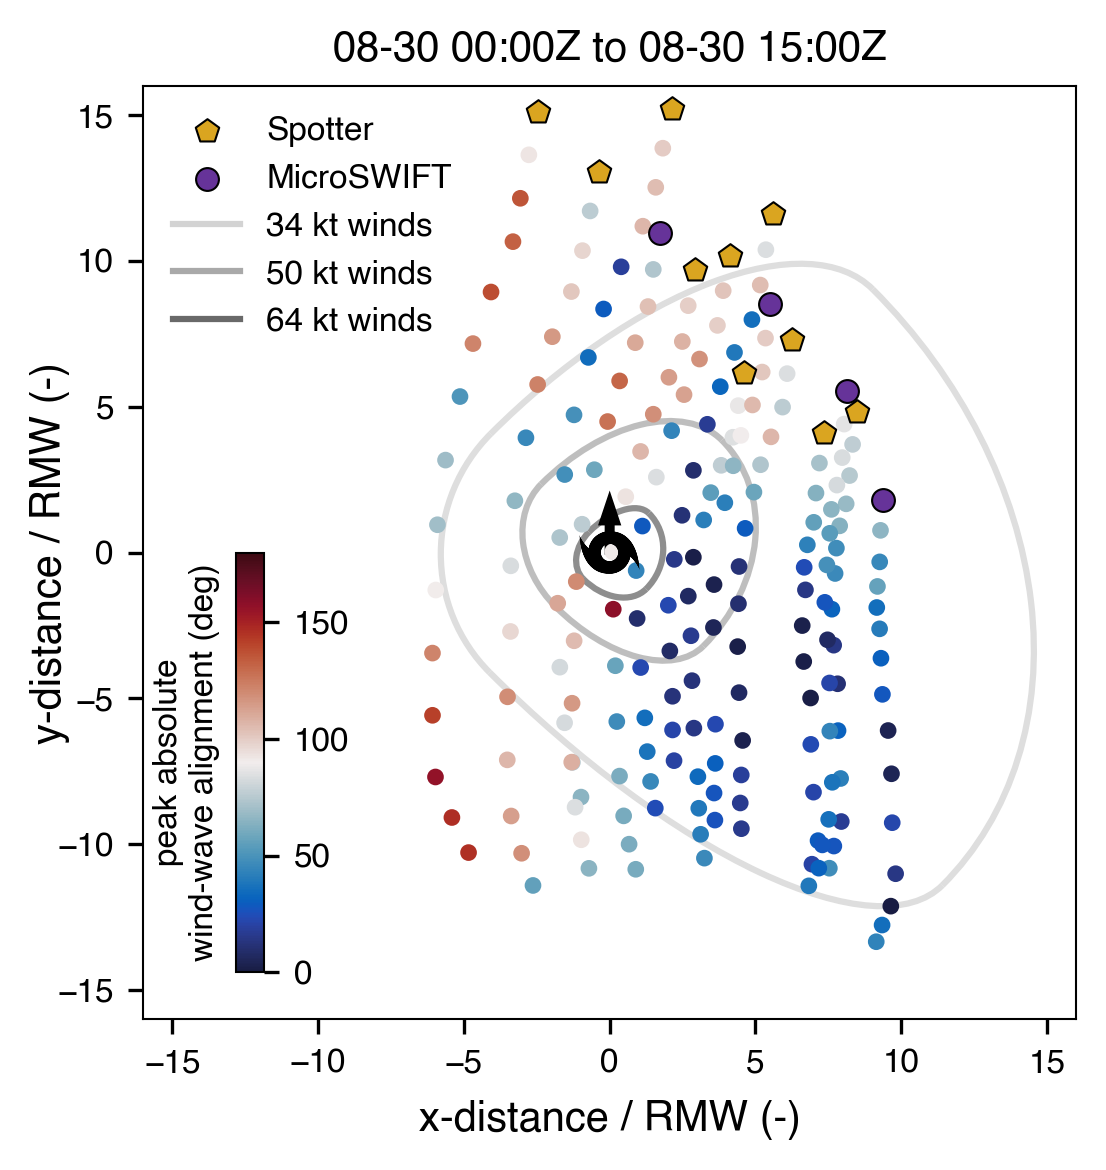

In [42]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_abs_peak_alignment_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_abs_peak_alignment_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'peak_wind_wave_alignment_abs'
    cmap = plotting.wind_wave_alignment_abs_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_abs_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.1, 0.05, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('peak absolute\nwind-wave alignment (deg)',
                   fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_abs_peak_alignment_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

#### Energy-weighted, categorized

Plot drift trails colored by energy-weighted (mean) categorized wind-wave alignment.

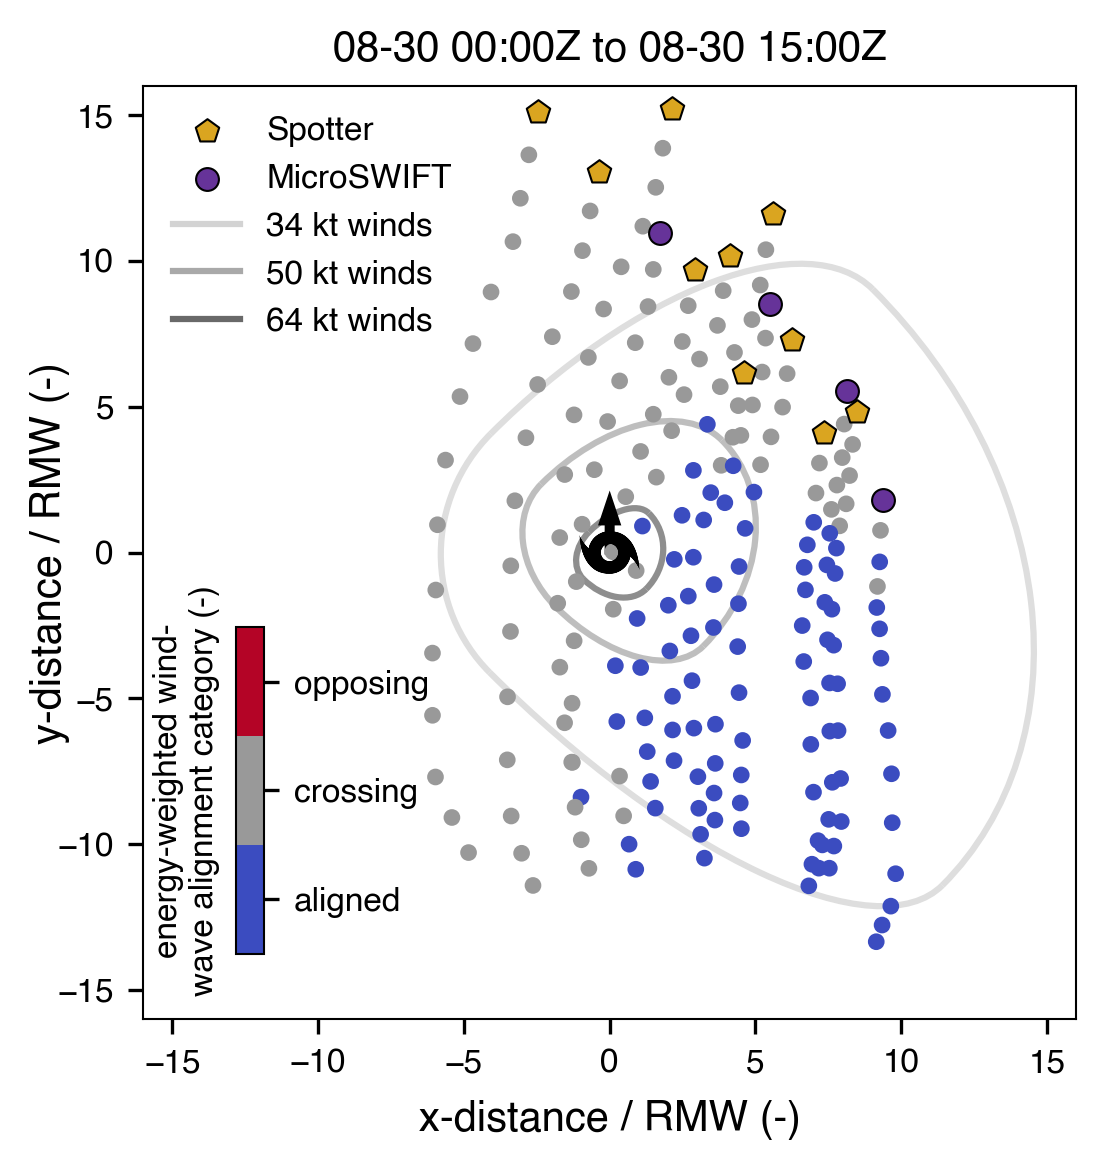

In [43]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_energy_weighted_alignment_category_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 400


def plot_energy_weighted_alignment_category_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mean_wind_wave_alignment_int'
    cmap = plotting.wind_wave_alignment_cat_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_cat_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.1, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar_ticks = list(plotting.alignment_cat_map_inv.keys())
    cbar.set_ticks(cbar_ticks, labels=[plotting.alignment_cat_map_inv[tick] for tick in cbar_ticks])
    cbar.set_label('energy-weighted wind-\nwave alignment category (-)',
                   fontsize=plotting.small_font_size)

    # # Add the graphical legend
    # im = plt.imread('./images/wind-wave_misalignment_legend.png')
    # # im_ax = ax.inset_axes([0.72, 0.7, 0.3, 0.3], transform=ax.transAxes)
    # im_ax = ax.inset_axes([0.61, 0.67, 0.5, 0.34], transform=ax.transAxes)
    # im_ax.imshow(im)
    # im_ax.axis('off')

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_energy_weighted_alignment_category_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

#### mss-weighted, categorized

Plot drift trails colored by mss-weighted, categorized wind-wave alignment.

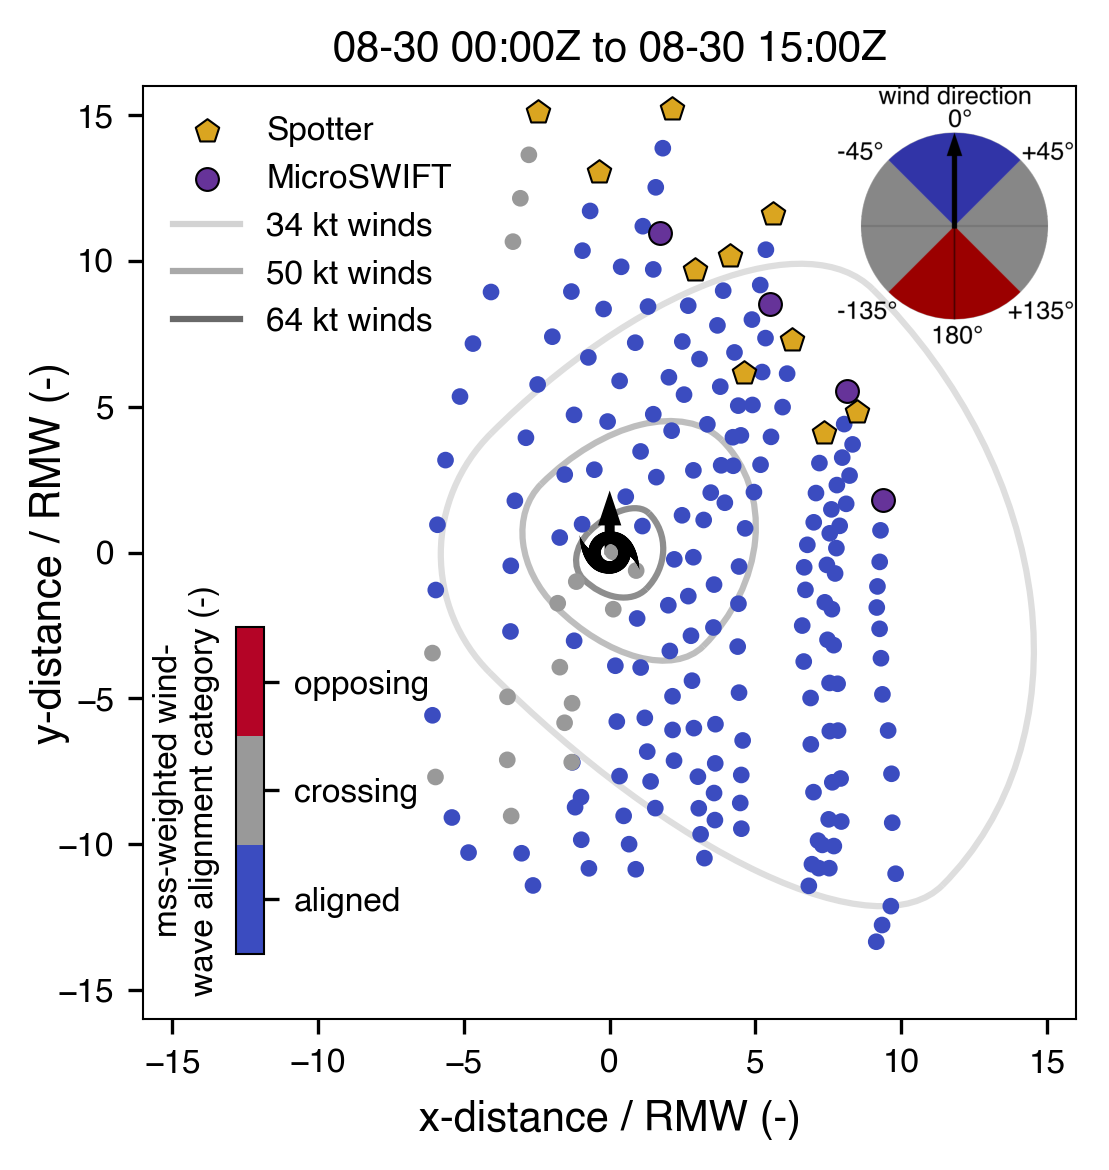

In [44]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_mss_weighted_alignment_category_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 400


def plot_mss_weighted_alignment_category_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'mss_weighted_wind_wave_alignment_int'
    cmap = plotting.wind_wave_alignment_cat_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_cat_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.1, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar_ticks = list(plotting.alignment_cat_map_inv.keys())
    cbar.set_ticks(cbar_ticks, labels=[plotting.alignment_cat_map_inv[tick] for tick in cbar_ticks])
    cbar.set_label('mss-weighted wind-\nwave alignment category (-)',
                   fontsize=plotting.small_font_size)

    # Add the graphical legend
    im = plt.imread('./images/wind-wave_misalignment_legend.png')
    im_ax = ax.inset_axes([0.72, 0.7, 0.3, 0.3], transform=ax.transAxes)
    im_ax.imshow(im)
    im_ax.axis('off')

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_mss_weighted_alignment_category_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

#### Peak, categorized

Plot drift trails colored by peak, categorized wind-wave alignment.

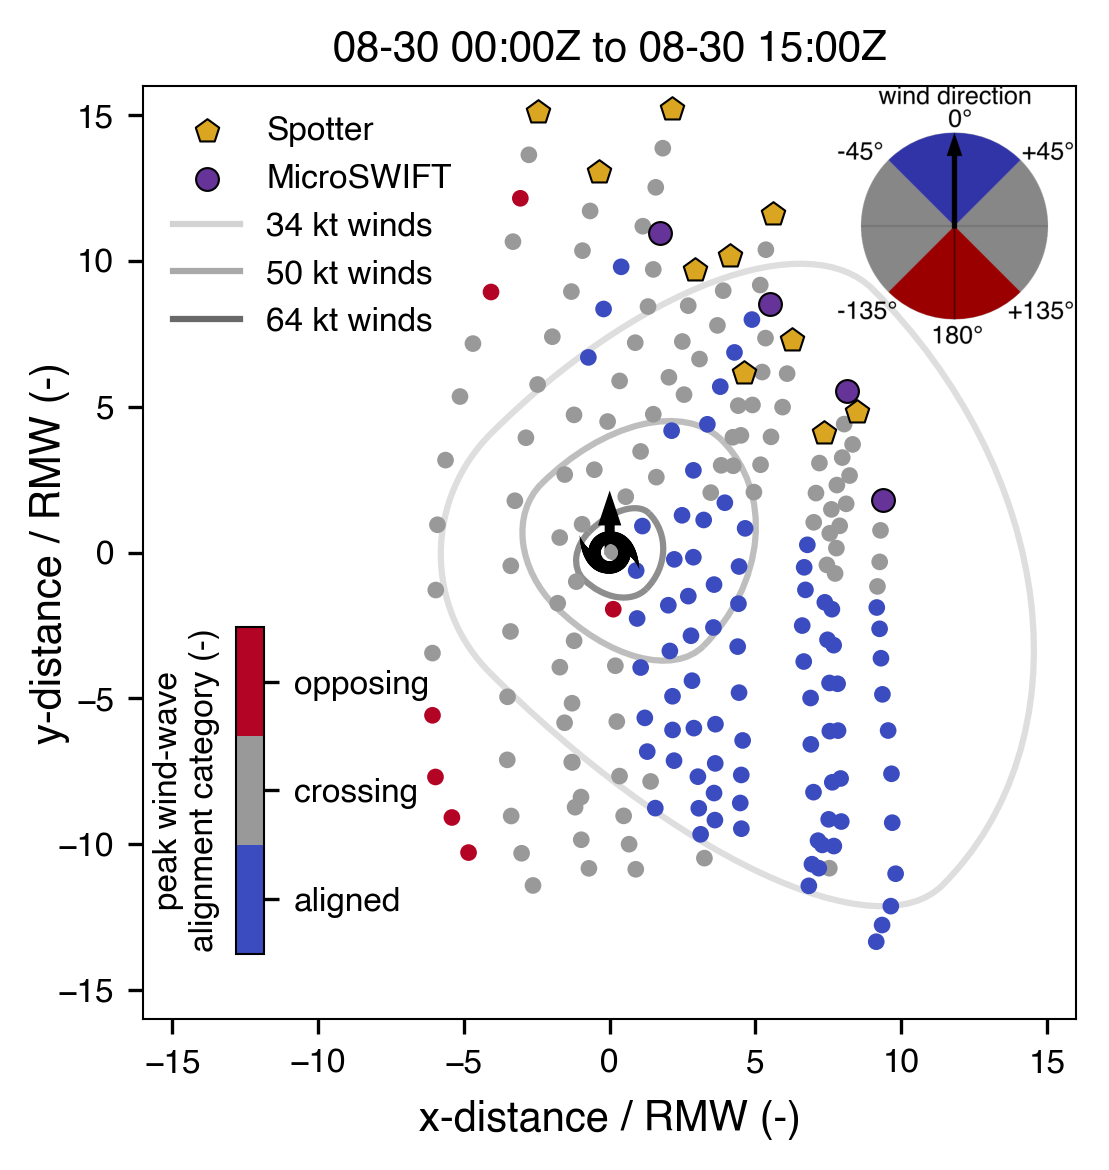

In [45]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_peak_alignment_category_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 400


def plot_peak_alignment_category_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'peak_wind_wave_alignment_int'
    cmap = plotting.wind_wave_alignment_cat_plot_kwargs['cmap']
    norm = plotting.wind_wave_alignment_cat_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.1, 0.07, 0.03, 0.35]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar_ticks = list(plotting.alignment_cat_map_inv.keys())
    cbar.set_ticks(cbar_ticks, labels=[plotting.alignment_cat_map_inv[tick] for tick in cbar_ticks])
    cbar.set_label('peak wind-wave\nalignment category (-)',
                   fontsize=plotting.small_font_size)

    # Add the graphical legend
    im = plt.imread('./images/wind-wave_misalignment_legend.png')
    im_ax = ax.inset_axes([0.72, 0.7, 0.3, 0.3], transform=ax.transAxes)
    im_ax.imshow(im)
    im_ax.axis('off')

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_peak_alignment_category_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)

### Drift speed

Plot drift trails colored by drift speed.

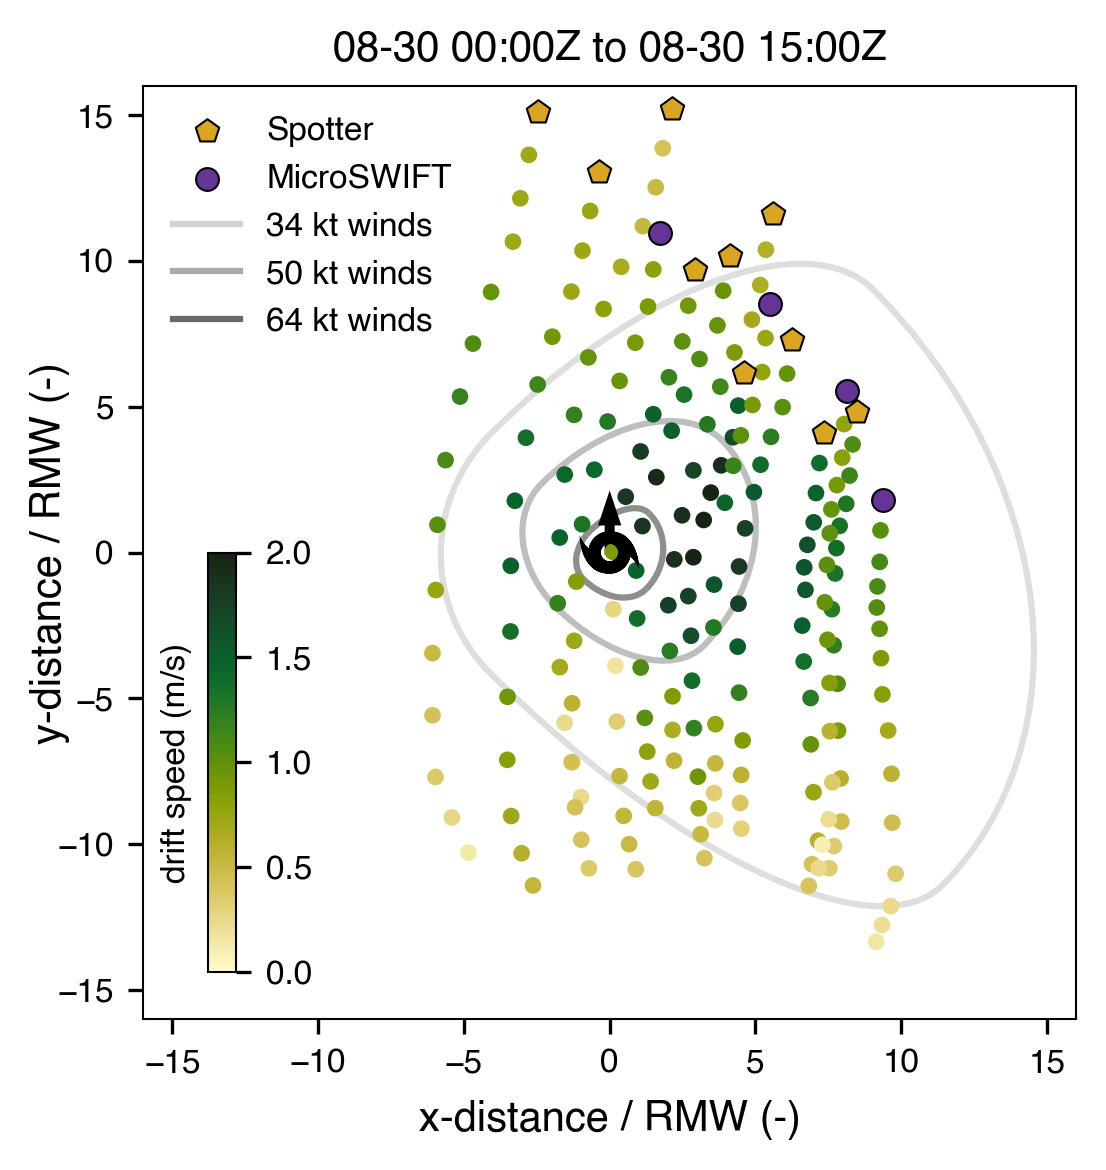

In [46]:
FIG_TITLE = (f"hurricane_idalia_storm_frame_drift_speed_rmw_norm")
FIG_SIZE = (4, 4)
FIG_RESOLUTION = 500


def plot_drift_speed_storm_frame(
    ax,
    **kwargs,
):
    color_column_name = 'drift_speed'
    cmap = plotting.drift_speed_plot_kwargs['cmap']
    norm = plotting.drift_speed_plot_kwargs['norm']

    marker_plots, trail_plots = plot_drifter_storm_frame_trails(
        ax=ax,
        color_column_name=color_column_name,
        norm=norm,
        cmap=cmap,
        **kwargs,
    )

    cbar, cax = plotting.create_inset_colorbar(
        trail_plots[0],
        ax,
        bounds=[0.07, 0.05, 0.03, 0.45]
    )
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('left')
    cbar.set_label('drift speed (m/s)', fontsize=plotting.small_font_size)

    return marker_plots, trail_plots, cbar


fig, ax = plt.subplots(figsize=FIG_SIZE)

# Title with date extent
ax.set_title(f"{time_slice.start.strftime('%m-%d %H:%MZ')} to "
             f"{time_slice.stop.strftime('%m-%d %H:%MZ')}")

plot_drift_speed_storm_frame(
    ax=ax,
    spotter_df=spotter_df.xs(time_slice, level='time'),
    microswift_df=microswift_df.xs(time_slice, level='time'),
    ibtracs_df=ibtracs_df.loc[time_slice],
)

fig.tight_layout()
# fig.savefig(FIG_TITLE + GLOBAL_SUFFIX + '.png', dpi=FIG_RESOLUTION)